$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\Parents}{\mathrm{Parents}}
\newcommand{\NonDesc}{\mathrm{NonDesc}}
\newcommand{\I}{\mathcal{I}}
\newcommand{\dsep}{\text{d-sep}}
$$

In [10]:
from __future__ import division

# scientific
%matplotlib inline
from matplotlib import pyplot as plt;
import numpy as np;
import sklearn as skl;
import sklearn.datasets;
import sklearn.cluster;

# ipython
import IPython;

# python
import os;

#####################################################

# image processing
import PIL;

# trim and scale images
def trim(im, percent=100):
    print("trim:", percent);
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        x = im.crop(bbox)
        return x.resize(((x.size[0]*percent)//100, (x.size[1]*percent)//100), PIL.Image.ANTIALIAS);


#####################################################

# daft (rendering PGMs)
import daft;

# set to FALSE to load PGMs from static images
RENDER_PGMS = True;

# decorator for pgm rendering
def pgm_render(pgm_func):
    def render_func(path, percent=100, render=None, *args, **kwargs):
        print("render_func:", percent);
        # render
        render = render if (render is not None) else RENDER_PGMS;
        
        if render:
            print("rendering");
            # render
            pgm = pgm_func(*args, **kwargs);
            pgm.render();
            pgm.figure.savefig(path, dpi=300);
            
            # trim
            img = trim(PIL.Image.open(path), percent);
            img.save(path, 'PNG');
        else:
            print("not rendering");
        
        # error
        if not os.path.isfile(path):
            raise Exception("Error:  Graphical model image %s not found.  You may need to set RENDER_PGMS=True." % path);
        
        # display
        return IPython.display.Image(filename=path);#trim(PIL.Image.open(path), percent);
    
    return render_func;

######################################################

# EECS 545:  Machine Learning

## Lecture 15:  Clustering, Mixture Models, and EM

- Instructor:  **Jacob Abernethy**
- Date:  March 14, 2016

*Lecture Exposition:*  Saket & Ben

## References

- **[MLAPP]** Murphy, Kevin. [*Machine Learning:  A Probabilistic Perspective*](https://mitpress.mit.edu/books/machine-learning-0).  2012.
- **[PRML]** Bishop, Christopher.  [*Pattern Recognition and Machine Learning*](http://research.microsoft.com/en-us/um/people/cmbishop/prml/).  2006.
- **[Koller & Friedman 2009]** Koller, Daphne and Nir Friedman.  [*Probabilistic Graphical Models*](https://mitpress.mit.edu/books/probabilistic-graphical-models).  2009.

## Outline

- Clustering & Mixture Models
    - Gaussian Mixture Models
- Expectation Maximization
    - Evidence Lower Bound
    - Variational Approximation

# Expectation Maximization
## Theoretical Perspective

> Uses material from **[MLAPP]**

### Review:  Inference & Learning

**Problem:**  Latent variable model.
- Observe data $\X = (x_1, \dots, x_n)$
- Generated from model $p$ with parameters $\theta$
- In the presence of latent variables $Z$

We seek to *learn* the parameters $\theta$ and/or *infer* the hidden values $Z$.

### Data Log-Likelihood

The **observed data log-likelihood** is given by 
$$
\begin{align}
\ell(\theta | \X) 
&= \log p(\X | \theta)
= \sum_{k=1}^N \log p(x_k | \theta) \\
&= \sum_{k=1}^N \left[ \log \sum_{z} p(x_k, z | \theta) \right]
\end{align}
$$

### Expectation Maximization

Our general approach will be to reason about the hidden variables through a proxy distribution $q$.
- Distribution $q$ is an approximation to the difficult $P(Z | \X, \theta)$
- We use $q$ to compute a lower bound on the log-likelihood.

### Evidence Lower Bound

Through Jensen's inequality, we obtain the **evidence lower bound (ELBO)**:
$$
\begin{align}
\ell(\theta | \X)
&= \log \sum_z p(\X, z | \theta) \\
&= \log \sum_z q(z) \frac{p(\X, z | \theta)}{q(z)} \\
&\geq \sum_z q(z) \ln \frac{p(\X, z | \theta)}{q(z)} \equiv \L(q, \theta)
\end{align}
$$

### Evidence Lower Bound

We can rewrite the lower bound $\L(q, \theta)$ as follows:
$$
\begin{align}
\ell(\theta | \X)
\geq \L(q,\theta)
&= \sum_z q(z) \log \frac{p(\X,z|\theta)}{q(z)} \\
&= \sum_q q(z) \log p(\X,z|\theta) - \sum_z q(z) \log q(z) \\
&= E_q[\log p(\X,Z|\theta)] - E_q[\log q(z)] \\
&= E_q[\log p(\X,Z|\theta)] + H[q]
\end{align}
$$

### ELBO:  Relationship to Relative Entropy

We have just shown that
$$
\begin{align}
\ell(\theta|\X) \geq \L(q,\theta)
&= E_q[\log p(\X,Z|\theta)] - E_q[\log q(z)] \\
&= E_q[\log p(\X,Z|\theta)] + H[q]
\end{align}
$$

This very closely resembles the formula for **relative entropy** 
$$
\begin{align}
D_{KL}(q || p) 
&= E_q[-\log p(Z)] + E_q[\log q(Z)] \\
&= H[q,p] - H[q]
\end{align}
$$

Except that the variables $X$ are clamped to our observations $X=\X$.
- So $P(\X,Z)$ is an *unnormalized* distribution.
- As it turns out, this does not set us back too far.

### ELBO:  Relationship to Relative Entropy

It is easy to show $\L(q,\theta)$ differs from a relative entropy by only a constant wrt $Z$:
$$
\begin{align*}
D_{KL}(q || p(Z|\X,\theta)
&= H(q, p(Z|\X,\theta)) - H(q) \\
&= E_q[ -\log p(Z|\X,\theta) ] - H(q) \\
&= E_q[ -\log p(Z,\X,\theta) ] - E_q[ -\log p(\X|\theta) ] - H(q) \\
&= E_q[ -\log p(Z,\X,\theta) ] + \log p(\X|\theta) - H(q) \\
&= -\mathcal{L}(q,\theta) + \mathrm{const.}
\end{align*}
$$

### ELBO:  Tightness

This yields a second proof of the ELBO, following from the nonnegativity of relative entropy.
$$
\log p(\X | \theta)
= D_{KL}(q || p(Z,\X | \theta)) + \mathcal{L}(q,\theta) 
\geq \mathcal{L}(q,\theta)
$$

The quality of our bound $\L(q,\theta)$ depends heavily on the choice of proxy distribution $q(Z)$.

> **Remark:** Maximizing $\L(q, \theta)$ with respect to $q$ is equivalent to minimizing the relative entropy between $q$ and the hidden posterior $P(Z|\X,\theta)$.

Hence, the optimal $q$ is exactly the hidden posterior, for which $\log p(\X|\theta) = \L(q,\theta)$.

### Expectation Maximization

Finding a global maximum of the likelihood is difficult in the presence of latent variables.
$$
\hat\theta_{ML} = \arg\max_\theta \ell(\theta | \X) = \arg\max_\theta \log p(\X|\theta)
$$

Instead, the **Expectation Maximization** algorithm gives an iterative procedure for finding a *local* maximum of the likelihood.
- Under the assumption that the hidden posterior $P(Z|\X,\theta)$ is tractable.
- Exploits the evidence lower bound $\ell(\theta|\X) \geq \L(q,\theta)$.

# DAFT

In [16]:
@pgm_render
def pgm_coinflip():
    pgm = daft.PGM([4,4], origin=[-2,-1], node_unit=0.8, grid_unit=2.0);
    # nodes
    pgm.add_node(daft.Node("z", r"$Z_n$", 0.7, 1));
    pgm.add_node(daft.Node("x", r"$X_n$", 1.3, 1, observed=True));
    pgm.add_node(daft.Node("theta", r"$\theta$", 1.3, 0.3));
    
    # edges
    pgm.add_edge("z", "x", head_length=0.08);
    pgm.add_edge("theta", "x", head_length=0.08);
    
    pgm.add_plate(daft.Plate([0.4,0.8,1.3,0.5], 
                             label=r"$\qquad\qquad\qquad\;\; N$",
                             shift=-0.1))
    return pgm;

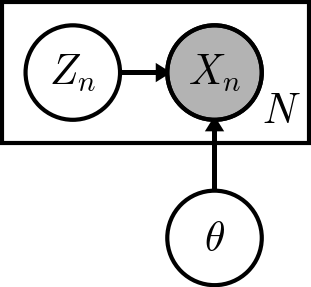

In [17]:
%%capture
pgm_coinflip("images/pgm/coinflip.png")